# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [2]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv
from scipy.integrate import quad
from scipy.signal import savgol_filter
from scipy import fftpack
from scipy.stats import zmap
import torch
torch.__version__
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Torch device: {device}")

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.colors as colors

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla
import alens_analysis.helpers as ahlp

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'


# Style and graphing
from cond_char_style import cond_char_sty
plt.style.use(cond_char_sty)



Torch device: cuda


# Functions

In [3]:
def poly_bead_rmsd(com_arr):
    # avg_rog = (aa.calc_rad_of_gyration(com_arr)).mean()
    tcom_arr = torch.from_numpy(com_arr).to(device)
    n = com_arr.shape[0]
    Ttot = com_arr.shape[-1]
    pol_com = tcom_arr.mean(axis=0)
    rmsd = torch.zeros(Ttot, device=device)
    for i in range(1,Ttot):
        tdiff_mat = (tcom_arr[:,:,i:] - pol_com[:,i:]) - (tcom_arr[:,:,:-i] - pol_com[:,:-i])
        rmsd[i] = torch.einsum('ijk,ijk->', tdiff_mat, tdiff_mat)/((Ttot-i)*n)
        
    return rmsd


In [4]:
def poly_autocorr(com_arr):
    avg_rog = (aa.calc_rad_of_gyration(com_arr)).mean()
    tcom_arr = torch.from_numpy(com_arr).to(device)
    n = com_arr.shape[0]
    Ttot = com_arr.shape[-1]
    pol_com = tcom_arr.mean(axis=0).to(device)
    autocorr = torch.zeros(Ttot, device=device)
    for i in range(1,Ttot):
        autocorr[i] = ((tcom_arr[:,:,i:] - pol_com[:,i:])* 
                                (tcom_arr[:,:,:-i] - pol_com[:,:-i])).sum()/((Ttot-i)*(avg_rog*avg_rog)*n)
        
    return autocorr


In [5]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def poly_autocorr_fast(com_arr):
    # avg_rog = (aa.calc_rad_of_gyration(com_arr)).mean()
    tcom_arr = torch.from_numpy(com_arr).to(device)
    pol_com = tcom_arr.mean(dim=0).to(device)
    nsteps = tcom_arr.shape[-1]
    n = next_pow_two(nsteps)

    # Compute the FFT and then (from that) the auto-correlation function
    f = torch.fft.fftn(tcom_arr-pol_com, dim=[-1], norm='forward')
    power_spec = torch.einsum('ijk,ijk->ik', f, torch.conj(f))
    autocorr = torch.fft.ifftn(power_spec, norm='forward', dim=[-1])[:,:nsteps].real
    return autocorr.mean(dim=0)

def poly_dist_autocorr_fast(com_arr):
    # avg_rog = (aa.calc_rad_of_gyration(com_arr)).mean()
    tcom_arr = torch.from_numpy(com_arr).to(device)
    pol_com = tcom_arr.mean(dim=0).to(device)
    nsteps = tcom_arr.shape[-1]
    n = next_pow_two(nsteps)
    tcom_dist = torch.norm(tcom_arr-pol_com, dim=1)

    # Compute the FFT and then (from that) the auto-correlation function
    f = torch.fft.fftn(tcom_dist, dim=[-1], norm='forward')
    power_spec = torch.einsum('ik,ik->ik', f, torch.conj(f))
    autocorr = torch.fft.ifftn(power_spec, norm='forward', dim=[-1])[:,:nsteps].real
    return autocorr.mean(dim=0)
        


In [6]:
def sep_autocorr(com_arr):
    tcom_arr = torch.from_numpy(com_arr).to(device)
    tsep_mat = (tcom_arr[:, None, :,:] - tcom_arr[None, :, :,:]).norm(dim=2).to(device)
    n = tsep_mat.shape[0]
    Ttot = tsep_mat.shape[-1]
    tcorr_d = torch.zeros(tsep_mat.shape[-1], device=device)
    avg_tsep_mat = tsep_mat.mean(dim=(0,1)).to(device)
    avg_sep = avg_tsep_mat.mean()
    for i in range(1,tsep_mat.shape[-1]):
        tcorr_d[i] = ((tsep_mat[:,:,i:] - avg_tsep_mat[i:]) * (tsep_mat[:,:,:-i]-avg_tsep_mat[:-i])).sum()/(n*n*avg_sep*avg_sep*(Ttot-i))
        
    return tcorr_d


In [7]:

def autocorr_fast(com_arr):
    tcom_arr = torch.from_numpy(com_arr).to(device)
    t0 = time.time()
    tsep_mat = (tcom_arr[:, None, :,:] - tcom_arr[None, :, :,:]).norm(dim=2).to(device)
    t1 = time.time()
    print(f'tsep_mat = {t1-t0}')
    nsteps = tsep_mat.shape[-1]
    n = next_pow_two(nsteps)
    t2 = time.time()
    print(f'power of two = {t2-t1}')

    # Compute the FFT and then (from that) the auto-correlation function
    f = torch.fft.fftn(tsep_mat, s=[2 * n], dim=[-1])
    t3 = time.time()
    print(f'fft = {t3-t2}')
    autocorr = torch.fft.ifftn(torch.einsum('ijk,ijk->ik', f,
                                       torch.conjugate(f)),
                             dim=[-1])[:nsteps].real
    t4 = time.time()
    print(f'ifft = {t4-t3}')

    autocorr /= 4 * n
    return autocorr


In [8]:
def monoExp(x, m, a):
    return m * np.exp(-a * x)

def negmonoExp(x, m, a):
    return m*(1. - np.exp(-a * x))

def line_func(x, a, b):
    return a*x + b

def fit_curve(x, y, fit_func):
    params, cv = curve_fit(fit_func, x, y)
    #print(params)
    squaredDiffs = np.square(y - fit_func(x, *params))
    squaredDiffsFromMean = np.square(y - np.mean(y))
    SEM = np.sqrt(np.sum(squaredDiffs))/x.size
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    #print(f"R² = {rSquared}")

    return params, rSquared, SEM
def func_powerlaw(x, a, b, c):
    return a + b * np.power(x,c)

def func_powerlaw_zero(x, a, b, c):
    return b * np.power(x,c)

def rsqr_val(func, x, y, popts):
    residuals = y - func(x, *popts)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    return 1. - (ss_res / ss_tot)

## Bead number scans

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


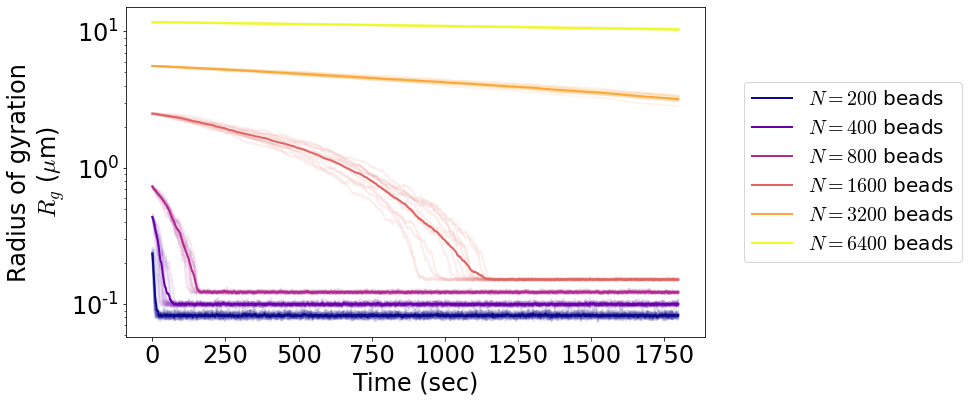

In [9]:
data_path = ceph_path / "CondCharPaper/22-09_aLc1_scan6.12_line200-6400_sticky_runs/simulations/"
# colors = list(mcolors.TABLEAU_COLORS.keys())
try:
    fig1, axarr1 = plt.subplots( figsize=(14, 6))
    # axarr1.sharey(axarr1[1])
    # axarr1.sharex(axarr1[1])
    mp = re.compile('line(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
    log_pvs = np.log10(param_vals)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = pl.cm.plasma(log_pvs)
    
    ss_ind = 1
    end_ind = -1
    start_bead = 0
    end_bead = None

    avg_ee_list = []
    std_ee_list = []
    for i, pd in enumerate(param_dirs):
        avg_ee_arrs = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('simulations/s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            rog = aa.calc_rad_of_gyration(com_arr)
            _ = axarr1.plot(time_arr, rog, color=colors[i], alpha=.1)
            avg_ee_arrs += [rog.tolist()]
        min_length = min([len(avg) for avg in avg_ee_arrs])
        
        
        avg_ee_arrs = np.array([avg[:min_length] for avg in avg_ee_arrs])
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1.plot(time_arr[:min_length], avg_ee_list[-1], color=colors[i], label=f"$N = {label}$ beads")
        # ci = (std_ee_list[-1]/np.sqrt(avg_ee_arrs.size(0))* 1.96) # 95% confidence interval
        # _ = axarr1[1].fill_between(time_arr[:min_length], (avg_ee_list[-1] - ci), (avg_ee_list[-1] + ci),color=colors[i], alpha=.25)
    
    _ = axarr1.set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
    _ = axarr1.set_xlabel('Time (sec)')
    _ = axarr1.set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

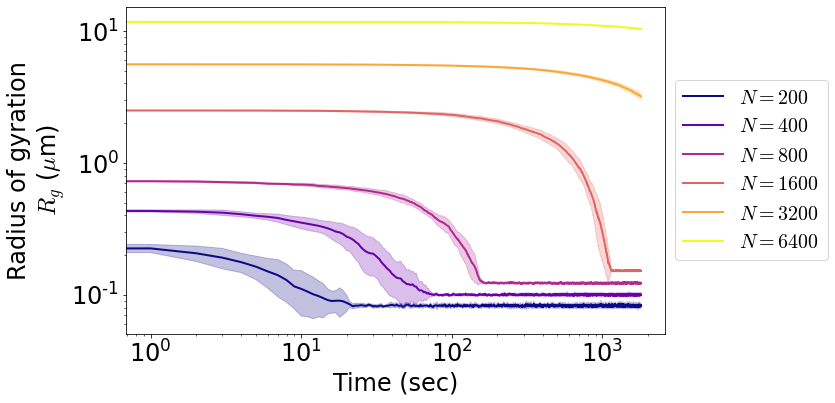

In [13]:
data_path = ceph_path / "CondCharPaper/22-09_aLc1_scan6.12_line200-6400_sticky_runs/simulations/"
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(12, 6))
    # axarr1[0].sharey(axarr1[1])
    # axarr1[0].sharex(axarr1[1])
    mp = re.compile('line(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
    log_pvs = np.log10(param_vals)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = pl.cm.plasma(log_pvs)
    
    ss_ind = 1
    end_ind = -1
    start_bead = 0
    end_bead = None

    avg_ee_list = []
    std_ee_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        avg_ee_arrs = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('simulations/s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            rog = aa.calc_rad_of_gyration(com_arr)
            # _ = axarr1[0].plot(time_arr, rog, color=colors[i], alpha=.1)
            avg_ee_arrs += [rog.tolist()]
        min_length = min([len(avg) for avg in avg_ee_arrs])
        
        avg_ee_arrs = np.array([avg[:min_length] for avg in avg_ee_arrs])
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1.plot(time_arr[:min_length], avg_ee_list[-1], color=colors[i], label=f"$N = {label}$ ")
        # ci = (std_ee_list[-1]/np.sqrt(avg_ee_arrs.shape[0])* 1.96) # 95% confidence interval
        ci = std_ee_list[-1]
        _ = axarr1.fill_between(time_arr[:min_length], (avg_ee_list[-1] - ci), (avg_ee_list[-1] + ci),color=colors[i], alpha=.25)
    
    _ = axarr1.set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
    _ = axarr1.set_xlabel('Time (sec)')
    _ = axarr1.set_yscale('log')
    _ = axarr1.set_xscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1.legend(loc='center left', bbox_to_anchor=(1.0, .5))
    # _ = axarr1.legend()
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

[200.0, 400.0, 800.0, 1600.0]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


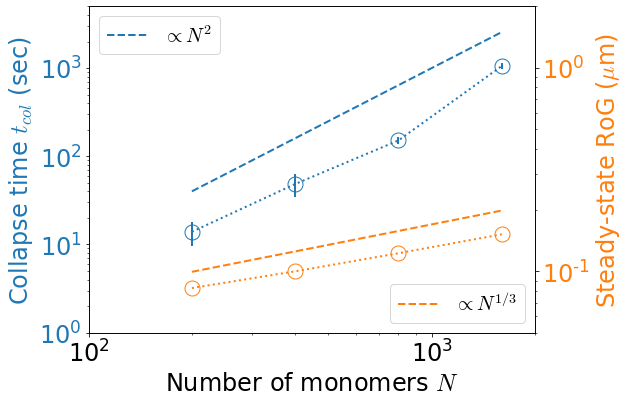

In [9]:
data_path = ceph_path / "CondCharPaper/22-09_aLc1_scan6.12_line200-6400_sticky_runs/simulations/"
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
rog_avg_ind = -600
pval_start_ind = 0
pval_end_ind = 4
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(8, 6))
    axarr2 = axarr1.twinx()
    mp = re.compile('line(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))[pval_start_ind:pval_end_ind]
    param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
    
    pvals = []
    collapse_times_avg = []
    collapse_times_std = []
    rog_avg = []
    rog_std = []
    for i, pd in tqdm(enumerate(param_dirs)):
        pvals += [float(re.split(r'(^[^\d]+)',str(pd.name))[1:][1])]
        sd_h5_data_lst = []
        rog_arr = []
        for h5p in pd.glob('simulations/s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        clps_times = []
        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            rog = aa.calc_rad_of_gyration(com_arr)
            clps_ind = ahlp.find_steady_state_ind(rog, [rog_avg_ind, None])
            clps_times += [time_arr[clps_ind]]
            rog_arr += [rog[clps_ind:].mean()]

        rog_avg += [np.mean(rog_arr)]
        rog_std += [np.std(rog_arr)]
        collapse_times_avg += [np.mean(clps_times)]
        collapse_times_std += [np.std(clps_times)]
    print(pvals)

    marker_style = dict(marker='o', linestyle=':', markersize=15, 
                        fillstyle='none')

    _ = axarr1.errorbar(pvals, collapse_times_avg, yerr=collapse_times_std, color='tab:blue' , **marker_style)
    _ = axarr1.plot(pvals, .001*np.power(pvals,2), c='tab:blue', linestyle='--', label= "$\propto N^2$")
    _ = axarr1.legend(loc='upper left')
        
    _ = axarr1.set_ylabel('Collapse time' + r" $t_{col}$ (sec)", color='tab:blue')
    _ = axarr1.set_xlabel('Number of monomers $N$ ')
    _ = axarr1.tick_params(axis='y', labelcolor='tab:blue')

    _ = axarr1.set_xscale('log')
    _ = axarr1.set_yscale('log')

    _ = axarr1.set_xlim(100, 2000)
    _ = axarr1.set_ylim(1, 5000)

    _ = axarr2.plot(pvals, .017*np.cbrt(pvals), c='tab:orange', linestyle='--', label= "$\propto N^{1/3}$")
    _ = axarr2.errorbar(pvals, rog_avg, yerr=rog_std, color='tab:orange', **marker_style)
    _ = axarr2.tick_params(axis='y', labelcolor='tab:orange')
    _ = axarr2.set_ylim(.05, 2)
    _ = axarr2.set_yscale('log')
    _ = axarr2.set_ylabel('Steady-state RoG ($\mu$m)', color='tab:orange')
    _ = axarr2.legend(loc='lower right')
except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

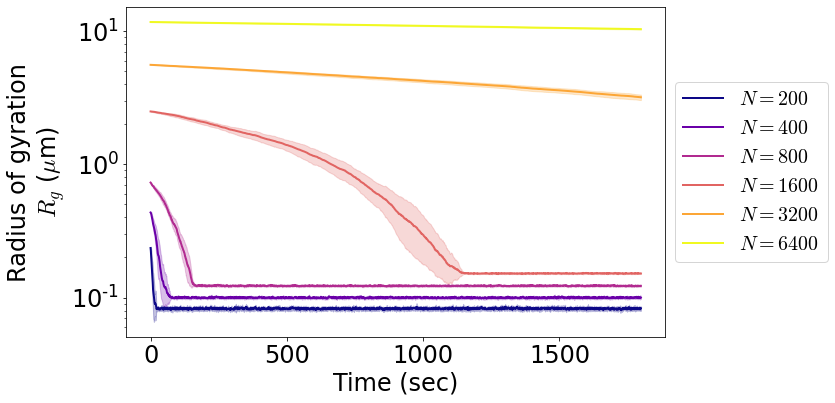

In [14]:
data_path = ceph_path / "CondCharPaper/22-09_aLc1_scan6.12_line200-6400_sticky_runs/simulations/"
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(12, 6))
    # axarr1[0].sharey(axarr1[1])
    # axarr1[0].sharex(axarr1[1])
    mp = re.compile('line(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
    log_pvs = np.log10(param_vals)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = pl.cm.plasma(log_pvs)
    
    ss_ind = 1
    end_ind = -1
    start_bead = 0
    end_bead = None

    avg_ee_list = []
    std_ee_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        avg_ee_arrs = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('simulations/s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            rog = aa.calc_rad_of_gyration(com_arr)
            # _ = axarr1[0].plot(time_arr, rog, color=colors[i], alpha=.1)
            avg_ee_arrs += [rog.tolist()]
        min_length = min([len(avg) for avg in avg_ee_arrs])
        
        avg_ee_arrs = np.array([avg[:min_length] for avg in avg_ee_arrs])
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1.plot(time_arr[:min_length], avg_ee_list[-1], color=colors[i], label=f"$N = {label}$ ")
        # ci = (std_ee_list[-1]/np.sqrt(avg_ee_arrs.shape[0])* 1.96) # 95% confidence interval
        ci = std_ee_list[-1]
        _ = axarr1.fill_between(time_arr[:min_length], (avg_ee_list[-1] - ci), (avg_ee_list[-1] + ci),color=colors[i], alpha=.25)
    
    _ = axarr1.set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
    _ = axarr1.set_xlabel('Time (sec)')
    _ = axarr1.set_yscale('log')
    # _ = axarr1.set_xscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1.legend(loc='center left', bbox_to_anchor=(1.0, .5))
    # _ = axarr1.legend()
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

# Collapse time and steady-state ROG for polymers that have collapsed